In [150]:
import json
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import cameo
from scipy import stats

In [2]:
%matplotlib inline

In [101]:
with open("../Data/Mutation_data/Mutations_to_gene_names.json") as infile:
    muts_to_genes = json.load(infile)
    
with open("../Data/Mutation_data/Strain_to_genes.json") as infile:
    strains_to_genes = json.load(infile)
    strains_to_genes = {k: v for k, v in strains_to_genes.items() if not k.startswith("12PD")}
    
with open("../Data/Mutation_data/All_strains_to_mutations.json") as infile:
    strains_to_muts = json.load(infile)
    strains_to_muts = {k: v for k, v in strains_to_muts.items() if not k.startswith("12PD")}

metab_dir = "/Users/krisj/Documents/PhD/Projects/ETH/Data/Metabolomics_data/"

fc_df = pd.read_csv(metab_dir + "Fold_changes.tsv", sep="\t", index_col=0)

with open(metab_dir + "all_ion_names.json") as infile:
    ion_names = json.load(infile)
    
with open(metab_dir + "bigg_model_ion_names.json") as infile:
    model_ion_names = json.load(infile)

muts_to_strains = {}
for s, muts in strains_to_muts.items():
    for mut in muts:
        muts_to_strains.setdefault(mut, []).append(s)

In [56]:
comp_name_order = [
    "1,2-propanediol", "2,3-butanediol", "HMDA", "putrescine", "glutarate",
    "adipate", "hexanoate", "octanoate", "coumarate", "isobutyrate", "butanol", "NaCl"
]

growth_df = pd.read_csv("../Data/Growth_data/Cross_tolerance/Cleaned_growth_rates.tsv", sep="\t")
long_growth_df = growth_df.copy()
growth_df = growth_df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "rel_growth_rate")[comp_name_order]
raw_growth_df = long_growth_df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "growth_rate")


m9_growth = pd.read_csv("../Data/Growth_data/M9/M9_normalised_growth.csv")
m9_growth = m9_growth[m9_growth["growth_rate"] != 0].groupby("strain").mean()

growth_df["M9"] = m9_growth["rel_growth_rate"]

In [134]:
model = cameo.load_model("iJO1366")

In [57]:
def tol_metric(row):
        
    if pd.isnull(row["coumarate"]):
        coum = row[comp_name_order].mean()
    else:
        coum = row["coumarate"]
        
    if pd.isnull(row["isobutyrate"]):
        ibua = row[comp_name_order].mean()
    else:
        ibua = row["isobutyrate"]
    if "butanol" in row:
        if pd.isnull(row["butanol"]):
            but = row[comp_name_order].mean()
        else:
            but = row["butanol"]
    return (
        (
            row[["HMDA", "putrescine"]].mean() + 
            row[["glutarate", "adipate"]].mean() + 
            row[["hexanoate", "octanoate"]].mean()
        )
        + ibua + row["2,3-butanediol"] + coum + but
    )

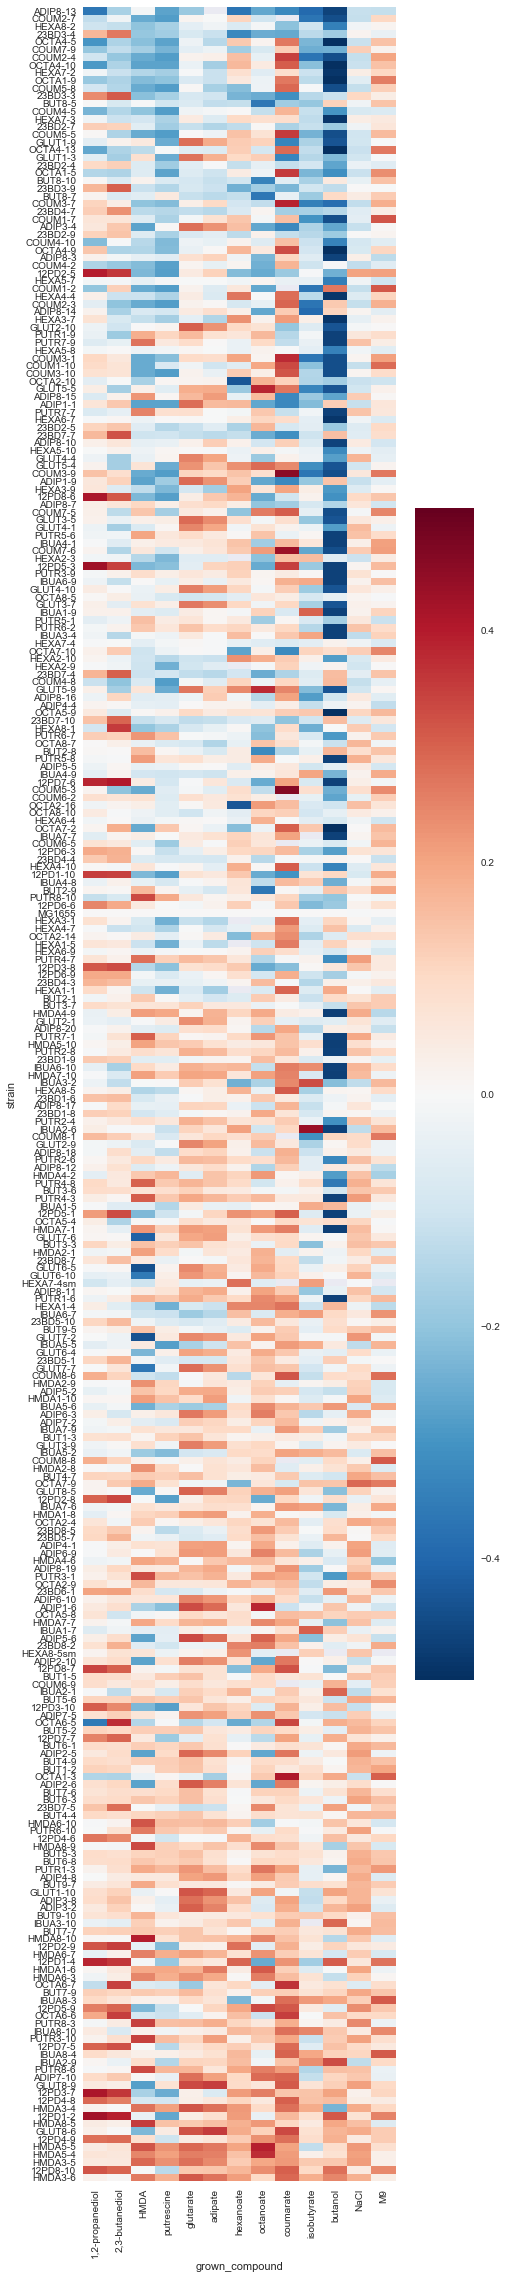

In [58]:
plot_df = growth_df.copy()

plot_df = plot_df.reindex(plot_df.apply(tol_metric, axis=1).sort_values().index)

plt.figure(figsize=[7, 40])
sbn.heatmap(plot_df)

In [59]:
plot_df = growth_df.copy()
plot_df["comp"] = plot_df.index.map(lambda x: x.split("-")[0][:-1])
plot_df["global"] = plot_df.apply(tol_metric, axis=1)

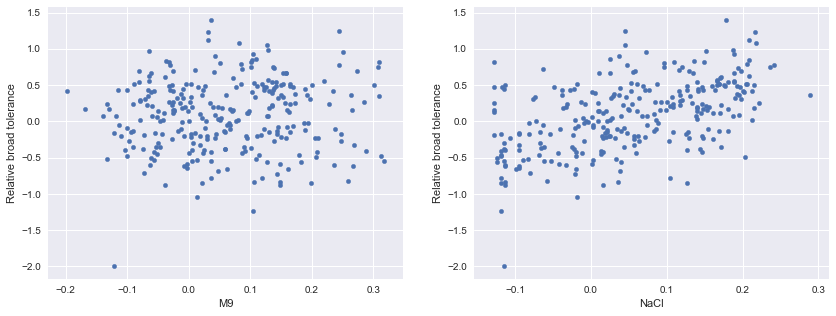

In [69]:
fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(1, 2, 1)
plot_df.plot(kind="scatter", x="M9", y="global", ax=ax)
plt.ylabel("Relative broad tolerance")
ax = fig.add_subplot(1, 2, 2)
plot_df.plot(kind="scatter", x="NaCl", y="global", ax=ax)
plt.ylabel("Relative broad tolerance")

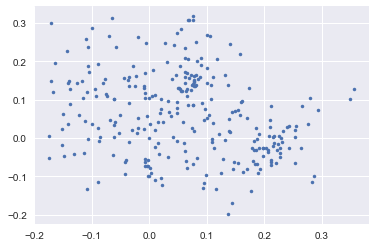

In [148]:
plt.plot(growth_df["adipate"], growth_df["M9"], ".")

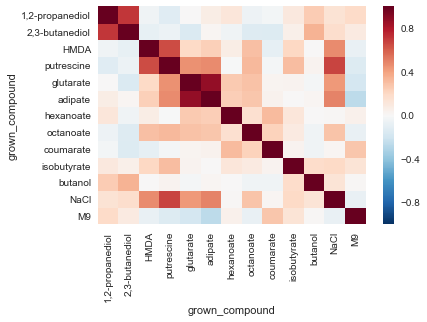

In [146]:
sbn.heatmap(growth_df.corr())

In [87]:
hmda_gene_df = pd.DataFrame(
    {k: {g: 1 for g in v} for k, v in strains_to_genes.items() if k.startswith("HMDA")}
).fillna(0).transpose()
hmda_gene_df["tol"] = hmda_gene_df.index.map(growth_df.apply(tol_metric, axis=1).get)

hmda_gene_df = hmda_gene_df[hmda_gene_df.corr()["tol"].sort_values().index]

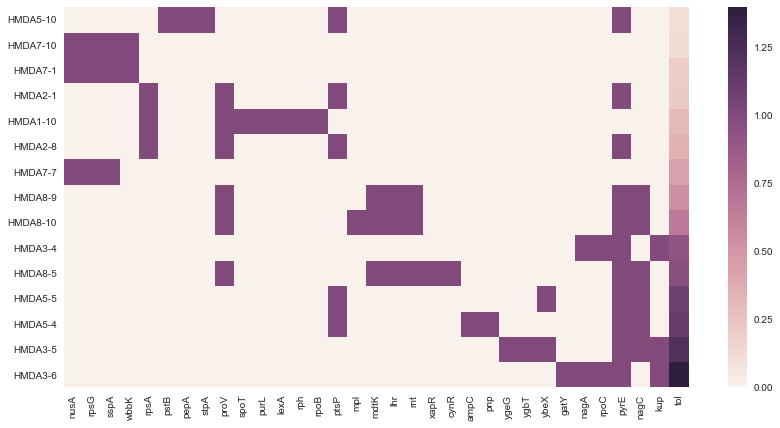

In [149]:
plt.figure(figsize=[14, 7])
sbn.heatmap(hmda_gene_df.sort_values("tol"))

In [158]:
stats.pearsonr(hmda_gene_df["tol"], (hmda_gene_df["nagA"] + hmda_gene_df["nagC"]))

(0.87389733858127527, 2.0612449739399058e-05)

In [86]:
hmda_gene_df.corr()["tol"].sort_values()

nusA   -0.461363
rpsG   -0.461363
sspA   -0.461363
wbbK   -0.445706
rpsA   -0.418316
pstB   -0.337171
pepA   -0.337171
stpA   -0.337171
proV   -0.260796
spoT   -0.212906
purL   -0.212906
lexA   -0.212906
rph    -0.212906
rpoB   -0.212906
ptsP   -0.118650
mpl     0.017629
mdtK    0.098907
lhr     0.098907
rnt     0.098907
xapR    0.205485
cynR    0.205485
ampC    0.297643
pnp     0.297643
ygeG    0.365726
ygbT    0.365726
ybeX    0.468837
gatY    0.474995
nagA    0.478900
rpoC    0.478900
pyrE    0.537414
nagC    0.557630
kup     0.635057
tol     1.000000
Name: tol, dtype: float64

In [74]:
[k + ": " + str(v) for k, v in strains_to_genes.items() if k.startswith("HMDA")]

["HMDA7-10: ['nusA', 'rpsG', 'sspA', 'wbbK']",
 "HMDA1-10: ['purL', 'spoT', 'proV', 'rpoB', 'lexA', 'rpsA', 'rph']",
 "HMDA7-1: ['nusA', 'rpsG', 'sspA', 'wbbK']",
 "HMDA2-1: ['ptsP', 'proV', 'rpsA', 'pyrE']",
 "HMDA5-10: ['ptsP', 'pyrE', 'pstB', 'stpA', 'pepA']",
 "HMDA7-7: ['nusA', 'rpsG', 'sspA']",
 "HMDA3-6: ['pyrE', 'rpoC', 'gatY', 'kup', 'nagA']",
 "HMDA8-9: ['pyrE', 'rnt', 'mdtK', 'proV', 'lhr', 'nagC']",
 "HMDA8-5: ['pyrE', 'cynR', 'rnt', 'mdtK', 'proV', 'lhr', 'nagC', 'xapR']",
 "HMDA2-8: ['pyrE', 'proV', 'ptsP', 'rpsA']",
 "HMDA5-5: ['ptsP', 'nagC', 'ybeX', 'pyrE']",
 "HMDA3-5: ['pyrE', 'ygbT', 'ygeG', 'ybeX', 'kup', 'nagC']",
 "HMDA5-4: ['pnp', 'ampC', 'nagC', 'ptsP', 'pyrE']",
 "HMDA3-4: ['pyrE', 'rpoC', 'kup', 'nagA']",
 "HMDA8-10: ['pyrE', 'rnt', 'mdtK', 'lhr', 'proV', 'mpl', 'nagC']"]

In [62]:
plot_df.corr()["global"].sort_values()

grown_compound
M9                 0.061295
1,2-propanediol    0.335124
hexanoate          0.347299
2,3-butanediol     0.350622
coumarate          0.352243
glutarate          0.379744
HMDA               0.386408
octanoate          0.397410
adipate            0.457195
putrescine         0.505985
isobutyrate        0.513903
NaCl               0.521715
butanol            0.613821
global             1.000000
Name: global, dtype: float64

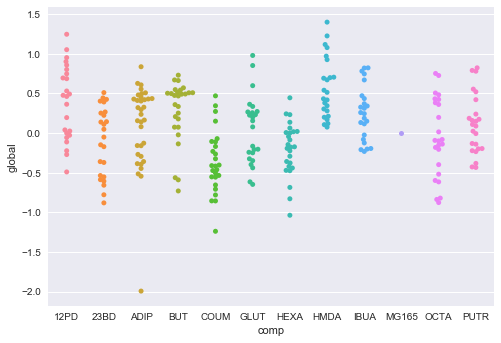

In [89]:
sbn.swarmplot(x="comp", y="global", data=plot_df)

In [43]:
plot_df.corr("pearson")["global"].sort_values()

grown_compound
hexanoate          0.276358
coumarate          0.278378
1,2-propanediol    0.284573
2,3-butanediol     0.366754
glutarate          0.377044
octanoate          0.378003
HMDA               0.397500
adipate            0.435032
putrescine         0.487021
isobutyrate        0.514789
NaCl               0.523678
butanol            0.607229
global             1.000000
Name: global, dtype: float64

In [100]:
fc_df

,strain,36,38,43,44,45,46,50,52,56,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,growth
0,23BD1-6,0.035027,0.083617,0.052528,0.085036,0.140603,0.140844,0.051536,0.120572,0.052707,...,-0.143985,-0.011729,-0.056894,-0.016653,0.091410,-0.012765,-0.024992,0.051019,-0.001874,-0.050983
1,23BD1-9,-0.027824,0.017906,0.040606,0.030120,0.069103,0.007252,-0.016203,0.054919,-0.151079,...,-0.124101,-0.108166,0.011310,0.033274,-0.011844,0.010544,-0.061867,-0.043444,-0.056901,-0.040857
2,23BD2-4,0.062024,0.028936,0.043314,0.020610,0.061160,0.020096,0.003159,0.075022,-0.025524,...,-0.093402,0.045266,0.037738,-0.097257,0.037499,-0.063371,-0.095204,-0.022951,-0.066606,-0.062622
3,23BD2-7,-0.093948,0.046157,0.027965,0.025289,0.029212,0.057429,0.040164,-0.166786,-0.080821,...,-0.042123,-0.064194,-0.069628,-0.004892,-0.051167,0.006037,-0.087049,-0.046826,-0.050143,0.062594
4,23BD2-9,-0.050732,-0.027925,0.004120,-0.008861,-0.156512,-0.005599,0.012088,-0.186005,-0.138510,...,-0.059274,-0.015030,0.051324,-0.117627,0.033973,-0.010156,0.009987,-0.022684,-0.032266,0.012426
5,23BD4-3,-0.009846,0.033237,0.034614,0.001114,0.157630,-0.018579,0.020194,-0.006387,-0.081590,...,-0.040578,-0.100471,0.000876,0.001547,-0.017804,-0.093113,-0.039082,0.045340,0.027285,0.052541
6,23BD4-4,0.013677,0.037561,0.088153,0.111135,-0.021219,0.191156,0.022503,-0.016686,-0.187019,...,-0.074587,-0.103086,0.071087,0.039257,0.071662,0.033314,-0.062365,-0.021607,0.018813,-0.113939
7,23BD4-7,-0.011577,0.081901,0.051800,0.036319,0.153349,0.140003,0.088238,0.044288,-0.020335,...,0.055419,-0.023818,-0.075063,-0.005615,0.067894,0.055048,-0.024671,0.045497,0.045888,0.035903
8,23BD5-1,0.022354,0.051635,0.039855,0.006870,0.007679,0.126178,-0.014486,-0.062462,-0.066894,...,0.053435,-0.134095,0.028649,-0.044467,-0.071115,0.032648,-0.030659,-0.026755,-0.026751,0.001808
9,23BD5-10,-0.028733,-0.036279,0.036512,-0.002016,0.081674,0.133684,0.006368,-0.069447,0.090229,...,-0.001662,-0.077938,-0.001738,0.029550,-0.007697,0.038745,-0.026247,-0.055326,0.019232,0.033512


In [116]:
test_df = fc_df[fc_df.index.str.startswith("HMDA")].copy()
print(test_df.shape)
test_df = test_df[[c for c in test_df.columns if not c == "growth" and model_ion_names[int(c)]]]
print(test_df.shape)
test_df["tol"] = test_df.index.map(hmda_gene_df["tol"].get)

(15, 811)
(15, 431)


In [117]:
test_df.corr()["tol"].sort_values()

850    -0.817409
298    -0.792215
144    -0.788803
344    -0.764756
667    -0.745388
698    -0.734588
481    -0.732782
656    -0.723883
141    -0.707000
118    -0.698757
139    -0.695593
120    -0.693586
287    -0.686218
286    -0.682717
838    -0.682507
116    -0.680042
345    -0.660633
198    -0.658013
279    -0.654993
115    -0.654649
280    -0.648616
132    -0.640921
581    -0.640546
360    -0.639329
247    -0.637320
451    -0.635117
650    -0.634710
215    -0.633764
935    -0.622151
237    -0.608377
          ...   
334     0.537382
470     0.542774
908     0.544283
723     0.545135
981     0.559934
887     0.560064
92      0.566370
200     0.568002
783     0.569317
881     0.570193
320     0.587646
143     0.600392
201     0.602426
385     0.623503
607     0.623986
525     0.634563
142     0.647435
721     0.651630
64      0.672775
1026    0.703595
565     0.751603
566     0.751917
460     0.756650
457     0.761087
244     0.777066
85      0.777906
317     0.808652
148     0.8139

In [142]:
ion_names[478]

'Cystathionine~L-Cystathionine~L-cystathionine dizwitterion'

In [141]:
model_ion_names[478]

['cyst__L']

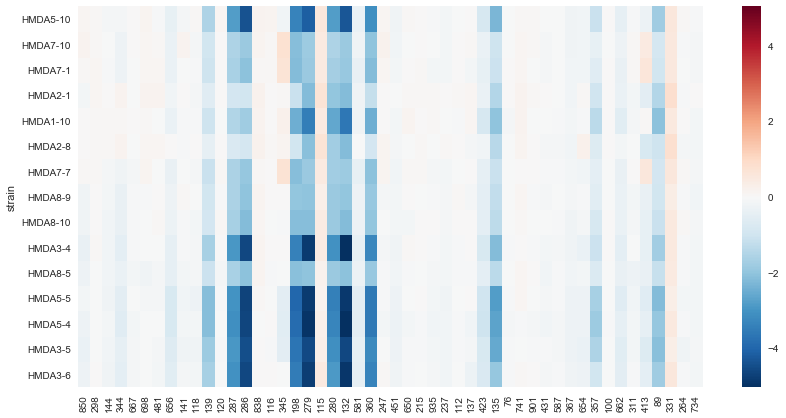

In [143]:
plot_df = test_df.copy()
plot_df = plot_df.sort_values("tol")
plot_df = plot_df[plot_df.corr()["tol"].sort_values().index]
plt.figure(figsize=[14, 7])
sbn.heatmap(plot_df.iloc[:, :50])

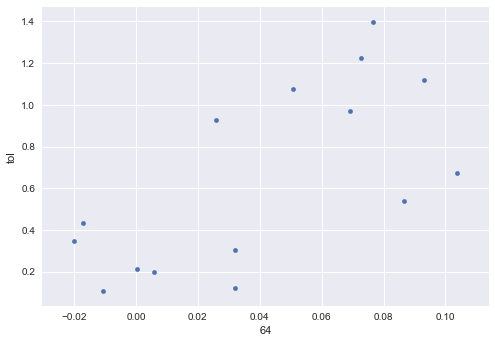

In [132]:
plot_df.plot(kind="scatter", x="64", y="tol")

In [136]:
model.metabolites.acglc__D_c.reactions

frozenset({<Reaction GLCATr at 0x131b1c668>})

In [137]:
model.reactions.GLCATr

Reaction identifier,GLCATr
Name,D-glucose O-acetyltransferase
Memory address,0x0131b1c668
Stoichiometry,accoa_c + glc__D_c <=> acglc__D_c + coa_c Acetyl-CoA + D-Glucose <=> 6-Acetyl-D-glucose + Coenzyme A
GPR,b0459
Lower bound,-1000.0
Upper bound,1000.0
